In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import numpy as np
import torch
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D

from scipy.stats import trim_mean

In [2]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    # c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    # return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

palette1 = ['#227c9d', '#17c3b2', '#a9def9', '#ffcb77', '#fe6d73']
palette2 = ['#227c9d', '#17c3b2', '#a9def9', '#ffcb77', '#fe6d73']
# scala
palette3 = ['#B3BEFF', '#959ED4', '#7D85B3', '#656C91', '#4D526F']

palette3 = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']
palette3_light = [adjust_lightness(c, 0.7) for c in palette3]
palette3_dark = [adjust_lightness(c, 1.3) for c in palette3]

icl_color = '#9BB0C1'

cromos = ['#FAEDCB', '#F7D9C4', '#C9E4DE', '#C6DEF1', '#DBCDF0', '#F2C6DE', '#F9C6C9']
cromos = [adjust_lightness(c, 1.4) for c in cromos]

In [3]:
def read_results(result_path):
    with open(result_path) as f:
        results = json.load(f)
    return results

# get statistics
def clean_results(results):
    to_return = {k: [] for k in results[0]['out'].keys()}
    for ele in results:
        for type, value in ele['eval'].items():
            to_return[type].append(value['output'])
    
    return to_return

# Single languages

## ITA

In [4]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/all_evaluated_icl4_tok30_ITA-ENG.json')

# compute accuracy for task
language_to_count = 'it'

avg_perplexity = {}
avg_perplexity_filtered = {}
perplexity_filtered = {}        # all data
avg_perplexity_filtered_tri = {}
ci_perplexity = {}
ci_perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))
    avg_perplexity_filtered_tri[k] = trim_mean(all_perplexity_filtered, 0.1)

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

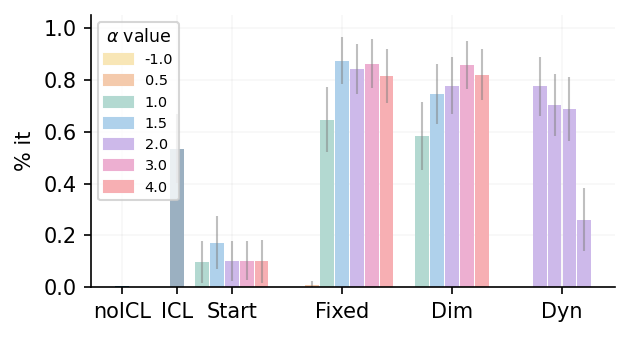

In [5]:
def plot_task(
    task,
    ci_s,
    language_to_count,
    filename,
    lower_legend=False,
):
    fig = plt.figure(figsize=(4.3, 2.5), dpi=150)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax0 = fig.add_subplot(spec[0])

    width = 0.25
    distance = 0.02
    error_kw = {"error_kw": dict(ecolor='gray', alpha=.5, lw=1)}

    ax0.bar(0 - 0*width - 0*distance, task['no_icl'], width, color=palette1[0], label = 'original model (baseline)')

    ax0.bar(1 - 0*width - 0*distance, task['icl'], width, color=icl_color, yerr=ci_s['icl'], **error_kw)

    ax0.bar(2 - 2*width - 2*distance, task['editedSTART_1.0'], width, color=cromos[2], yerr=ci_s['editedSTART_1.0'], **error_kw)
    ax0.bar(2 - 1*width - 1*distance, task['editedSTART_1.5'], width, color=cromos[3], yerr=ci_s['editedSTART_1.5'], **error_kw)
    ax0.bar(2 - 0*width - 0*distance, task['editedSTART_2.0'], width, color=cromos[4], yerr=ci_s['editedSTART_2.0'], **error_kw)
    ax0.bar(2 + 1*width + 1*distance, task['editedSTART_3.0'], width, color=cromos[5], yerr=ci_s['editedSTART_3.0'], **error_kw)
    ax0.bar(2 + 2*width + 2*distance, task['editedSTART_4.0'], width, color=cromos[6], yerr=ci_s['editedSTART_4.0'], **error_kw)

    ax0.bar(4 - 3*width - 3*distance, task['edited_-1.0'],width, color=cromos[0], yerr=ci_s['edited_-1.0'], **error_kw)
    ax0.bar(4 - 2*width - 2*distance, task['edited_0.5'], width, color=cromos[1], yerr=ci_s['edited_0.5'], **error_kw)
    ax0.bar(4 - 1*width - 1*distance, task['edited_1.0'], width, color=cromos[2], yerr=ci_s['edited_1.0'], **error_kw)
    ax0.bar(4 + 0*width - 0*distance, task['edited_1.5'], width, color=cromos[3], yerr=ci_s['edited_1.5'], **error_kw)
    ax0.bar(4 + 1*width + 1*distance, task['edited_2.0'], width, color=cromos[4], yerr=ci_s['edited_2.0'], **error_kw)
    ax0.bar(4 + 2*width + 2*distance, task['edited_3.0'], width, color=cromos[5], yerr=ci_s['edited_3.0'], **error_kw)
    ax0.bar(4 + 3*width + 3*distance, task['edited_4.0'], width, color=cromos[6], yerr=ci_s['edited_4.0'], **error_kw)

    ax0.bar(6 - 2*width - 2*distance, task['editedDIM_1.0'], width, color=cromos[2], yerr=ci_s['editedDIM_1.0'], **error_kw)
    ax0.bar(6 - 1*width - 1*distance, task['editedDIM_1.5'], width, color=cromos[3], yerr=ci_s['editedDIM_1.5'], **error_kw)
    ax0.bar(6 - 0*width - 0*distance, task['editedDIM_2.0'], width, color=cromos[4], yerr=ci_s['editedDIM_2.0'], **error_kw)
    ax0.bar(6 + 1*width + 1*distance, task['editedDIM_3.0'], width, color=cromos[5], yerr=ci_s['editedDIM_3.0'], **error_kw)
    ax0.bar(6 + 2*width + 2*distance, task['editedDIM_4.0'], width, color=cromos[6], yerr=ci_s['editedDIM_4.0'], **error_kw)

    ax0.bar(8- 1.5*width - 1.5*distance, task['dynamic_p0.5'], width, color=cromos[4], yerr=ci_s['dynamic_p0.5'], **error_kw)
    ax0.bar(8- 0.5*width - 0.5*distance, task['dynamic_p0.6'], width, color=cromos[4], yerr=ci_s['dynamic_p0.6'], **error_kw)
    ax0.bar(8+ 0.5*width + 0.5*distance, task['dynamic_p0.7'], width, color=cromos[4], yerr=ci_s['dynamic_p0.7'], **error_kw)
    ax0.bar(8+ 1.5*width + 1.5*distance, task['dynamic_p0.95'], width, color=cromos[4], yerr=ci_s['dynamic_p0.95'], **error_kw)

    x0_labels = [
        'noICL', 'ICL', 
        'Start\n',
        'Fixed\n', 
        'Dim',
        'Dyn',
    ]
    ax0.set_xticks([0, 1, 2, 4, 6, 8])
    ax0.set_xticklabels(x0_labels)
    ax0.set_ylim(0, 1.05)

    ax0.set_ylabel(f'% {language_to_count}')
    ax0.grid(alpha=0.1)
    ax0.set_axisbelow(True)
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    # ax0.set_title(title)

    legend_patches = [
        mpatches.Patch(color=cromos[0], label='-1.0'),
        mpatches.Patch(color=cromos[1], label='0.5'),
        mpatches.Patch(color=cromos[2], label='1.0'),
        mpatches.Patch(color=cromos[3], label='1.5'),
        mpatches.Patch(color=cromos[4], label='2.0'),
        mpatches.Patch(color=cromos[5], label='3.0'),
        mpatches.Patch(color=cromos[6], label='4.0'),
    ]
    legend = ax0.legend(
        handles=legend_patches,# labels=amount_of_edit, 
        # loc='lower left' if lower_legend else 'upper left',
        title=r'$\alpha$ value', 
        fontsize='x-small',
        ncol=1, handler_map = {list: HandlerTuple(None)}
    )
    plt.setp(legend.get_title(),fontsize='small')
    fig.tight_layout()
    fig.savefig(f'./media/single/{filename}.pdf', format='pdf', bbox_inches='tight')

plot_task(
    task=avg_language,
    ci_s=ci_language,
    language_to_count=language_to_count,
    filename='ITA',
)

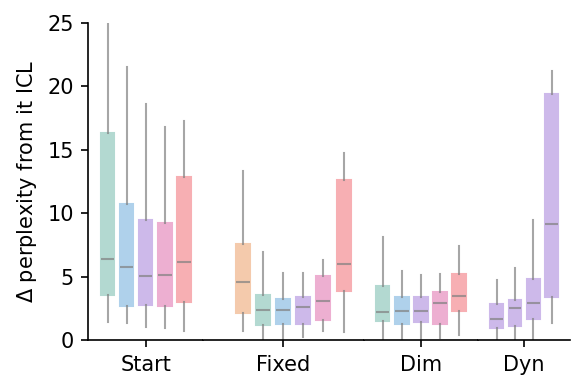

In [6]:
def plot_perplexity(
    perplexity,
    # ci_s,
    language_to_count,
    # title,
    filename,
    max_value=25,
    legend_on_ax=2,
):

    error_kw = {"error_kw": dict(ecolor='gray', alpha=.7, lw=1)}
    start_data = [
        perplexity['delta_editedSTART_1.0'],
        perplexity['delta_editedSTART_1.5'],
        perplexity['delta_editedSTART_2.0'],
        perplexity['delta_editedSTART_3.0'],
        perplexity['delta_editedSTART_4.0'],
    ]
    fixed_data = [
        perplexity['delta_edited_-1.0'],
        perplexity['delta_edited_0.5'],
        perplexity['delta_edited_1.0'],
        perplexity['delta_edited_1.5'],
        perplexity['delta_edited_2.0'],
        perplexity['delta_edited_3.0'],
        perplexity['delta_edited_4.0'],
    ]

    diminishing_data = [
        perplexity['delta_editedDIM_1.0'],
        perplexity['delta_editedDIM_1.5'],
        perplexity['delta_editedDIM_2.0'],
        perplexity['delta_editedDIM_3.0'],
        perplexity['delta_editedDIM_4.0'],
    ]
    dynamic_data = [
        perplexity['delta_dynamic_0.5'],
        perplexity['delta_dynamic_0.6'],
        perplexity['delta_dynamic_0.7'],
        perplexity['delta_dynamic_0.95'],
    ]

    
    fig, axes = plt.subplots(
        figsize=(4, 2.7), dpi=150,
        nrows=1, ncols=4, sharey=True,
        gridspec_kw={'width_ratios': [5, 7, 5, 4]},
    )
    ax0, ax1, ax2, ax3 = axes
    ax0.set_ylim(0, max_value)

    bplot = ax0.boxplot(start_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
    for w in bplot['whiskers']:
        w.set_color('gray')
        w.set_alpha(error_kw['error_kw']['alpha'])
    for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        median.set_color('gray')
        median.set_alpha(error_kw['error_kw']['alpha'])

    bplot = ax1.boxplot(fixed_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
    for w in bplot['whiskers']:
        w.set_color('gray')
        w.set_alpha(error_kw['error_kw']['alpha'])
    for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[0:]):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        median.set_color('gray')
        median.set_alpha(error_kw['error_kw']['alpha'])

    bplot = ax2.boxplot(diminishing_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
    for w in bplot['whiskers']:
        w.set_color('gray')
        w.set_alpha(error_kw['error_kw']['alpha'])
    for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        median.set_color('gray')
        median.set_alpha(error_kw['error_kw']['alpha'])

    bplot = ax3.boxplot(dynamic_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
    for w in bplot['whiskers']:
        w.set_color('gray')
        w.set_alpha(error_kw['error_kw']['alpha'])
    for patch, median in zip(bplot['boxes'], bplot['medians']):
        patch.set_facecolor(cromos[4])
        patch.set_edgecolor(cromos[4])
        median.set_color('gray')
        median.set_alpha(error_kw['error_kw']['alpha'])

    ax0.set_xlim(0, 6)
    ax1.set_xlim(0, 8)
    ax2.set_xlim(0, 6)
    ax3.set_xlim(0, 5)

    ax0.set_xticks([3], ['Start'])
    ax1.set_xticks([4], ['Fixed'])
    ax2.set_xticks([3], ['Dim'])
    ax3.set_xticks([2.5], ['Dyn'])

    ax0.set_ylabel(r'$\Delta$ perplexity from {lang} ICL'.format(lang=language_to_count))
    # ax0.grid(alpha=0.1)
    # ax0.set_axisbelow(True)
    # ax0.set_title(title) 
    for i, ax in enumerate(axes):
        if i > 0:
            ax.spines['left'].set_visible(False)
            ax.get_yaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # legend_patches = [
    #     mpatches.Patch(color=cromos[0], label='-1.0'),
    #     mpatches.Patch(color=cromos[1], label=' 0.5'),
    #     mpatches.Patch(color=cromos[2], label=' 1.0'),
    #     mpatches.Patch(color=cromos[3], label=' 1.5'),
    #     mpatches.Patch(color=cromos[4], label=' 2.0'),
    #     mpatches.Patch(color=cromos[5], label=' 3.0'),
    #     mpatches.Patch(color=cromos[6], label=' 4.0'),
    # ]
    # legend = axes[legend_on_ax].legend(
    #     handles=legend_patches,# labels=amount_of_edit, 
    #     # loc='upper left', 
    #     title=r'$\alpha$ value', 
    #     ncol=1, fontsize='x-small', handler_map = {list: HandlerTuple(None)}
    # )
    # plt.setp(legend.get_title(),fontsize='small')

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.0)
    fig.savefig(f'./media/single/{filename}.pdf', format='pdf', bbox_inches='tight')

plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count=language_to_count,
    filename='ITA-ppl',
)

## FRA

In [7]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/FRA/diff/all_evaluated_icl4_tok30_FRA-ENG.json')

# compute accuracy for task
language_to_count = 'fr'

avg_perplexity = {}
avg_perplexity_filtered = {}
avg_perplexity_filtered_tri = {}
ci_perplexity = {}
ci_perplexity_filtered = {}
perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))
    avg_perplexity_filtered_tri[k] = trim_mean(all_perplexity_filtered, 0.1)
    avg_perplexity_filtered_tri[k] = np.median(all_perplexity_filtered)

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

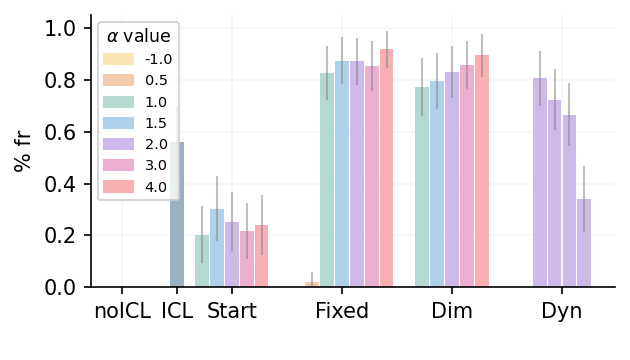

In [8]:
plot_task(
    task=avg_language,
    ci_s=ci_language,
    language_to_count=language_to_count,
    filename='FRA',
)

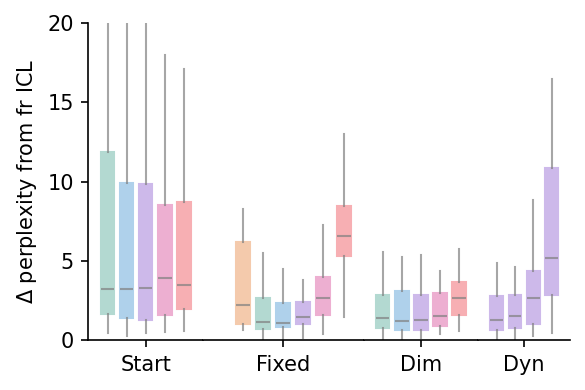

In [9]:
plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count=language_to_count,
    filename='FRA-ppl',
    max_value=20,
)

## SPA

In [10]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/SPA/diff/all_evaluated_icl4_tok30_SPA-ENG.json')

# compute accuracy for task
language_to_count = 'es'

avg_perplexity = {}
avg_perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}
perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

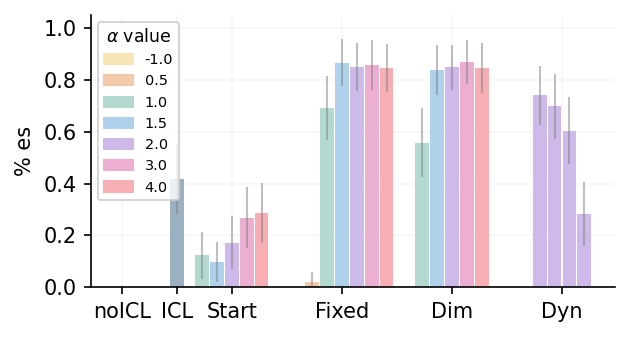

In [11]:
plot_task(
    task=avg_language,
    ci_s=ci_language,
    language_to_count=language_to_count,
    filename='SPA',
)

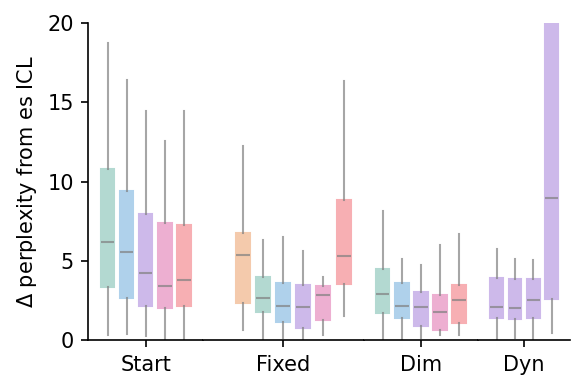

In [12]:
plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count=language_to_count,
    filename='SPA-ppl',
    max_value=20,
)

## CH

In [13]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ZHO/diff/all_evaluated_icl4_tok30_ZHO-ENG.json')

# compute accuracy for task
language_to_count = 'zh-cn'

avg_perplexity = {}
avg_perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}
perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    label_to_count = 'unsafe'
    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

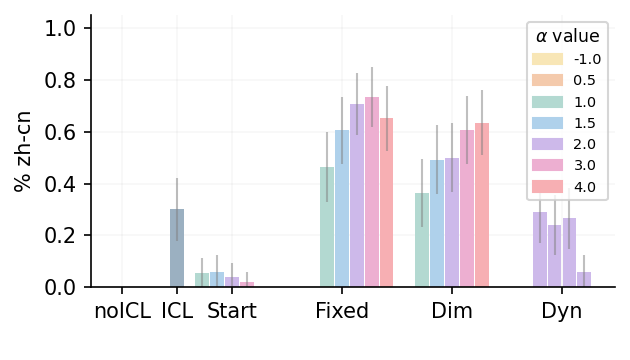

In [14]:
plot_task(
    task=avg_language,
    ci_s=ci_language,
    language_to_count=language_to_count,
    filename='ZHO',
)

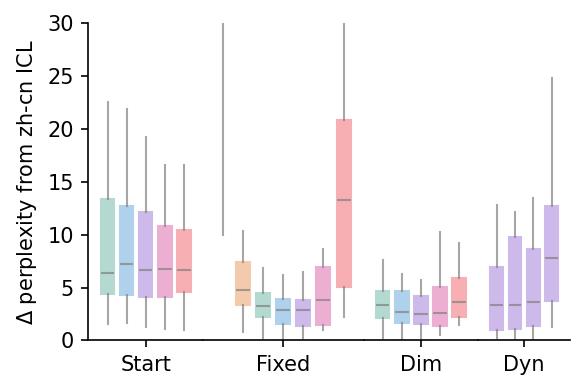

In [15]:
plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count=language_to_count,
    filename='ZHO-ppl',
    max_value=30,
)

# Unsafe / Safe

## Safe

In [16]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENsafe/diff/all_evaluated_icl4_tok30_ENsafe-ENunsafe.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = 'safe'

avg_perplexity = {}
avg_perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}
perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
ci_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count and ele['eval_task']['icl']['output'] == label_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity
    all_scores = [ele['eval_task'][k][label_to_count] for ele in ita_res]
    ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

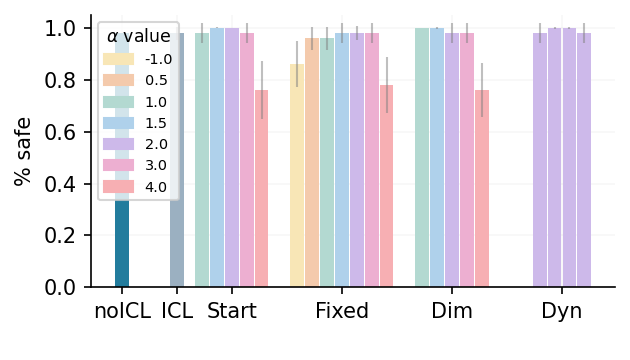

In [17]:
plot_task(
    task=avg_labels,
    ci_s=ci_labels,
    language_to_count=label_to_count,
    filename='ENsafe',
)

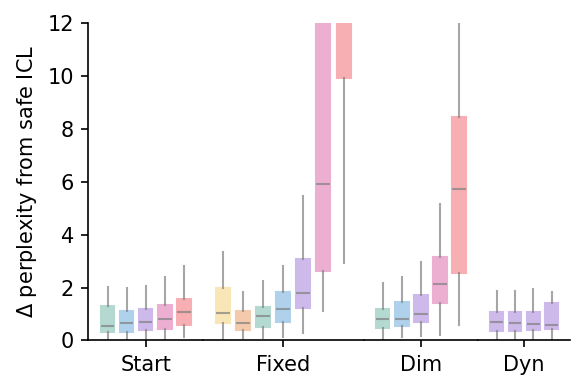

In [18]:
plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count='safe',
    filename='ENsafe-ppl',
    max_value=12,
    legend_on_ax=0,
)

## Unsafe

In [19]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENunsafe/diff/all_evaluated_icl4_tok30_ENunsafe-ENsafe.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = 'unsafe'

avg_perplexity = {}
avg_perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}
perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
ci_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count and ele['eval_task']['icl']['output'] == label_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [ele['eval_task'][k]['output'] for ele in ita_res]
    avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity
    all_scores = [ele['eval_task'][k][label_to_count] for ele in ita_res]
    ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

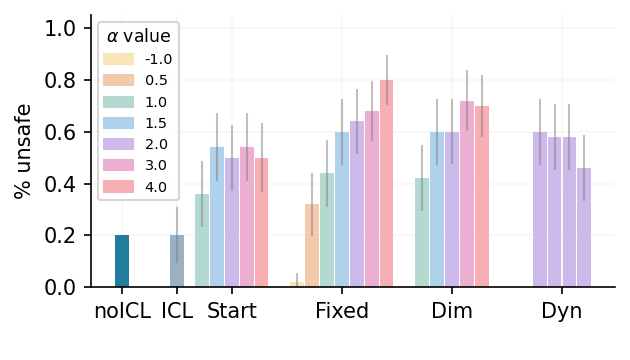

In [20]:
plot_task(
    task=avg_labels,
    ci_s=ci_labels,
    language_to_count=label_to_count,
    filename='ENunsafe',
)

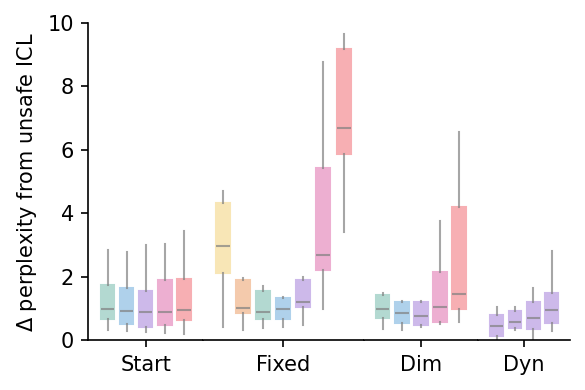

In [21]:
plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count='unsafe',
    filename='ENunsafe-ppl',
    max_value=10,
    legend_on_ax=0,
)

# Formality

## i2f

In [22]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENi2f/diff/all_evaluated_icl4_tok30_ENi2f-ENf2i.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = '0'

avg_perplexity = {}
avg_perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}
perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
ci_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count and str(ele['eval_task']['icl']['output']) == label_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [str(ele['eval_task'][k]['output']) for ele in ita_res]
    avg_labels[k] = all_labels.count(str(label_to_count)) / len(all_labels)
    all_scores = [ele['eval_task'][k][label_to_count] for ele in ita_res]
    ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

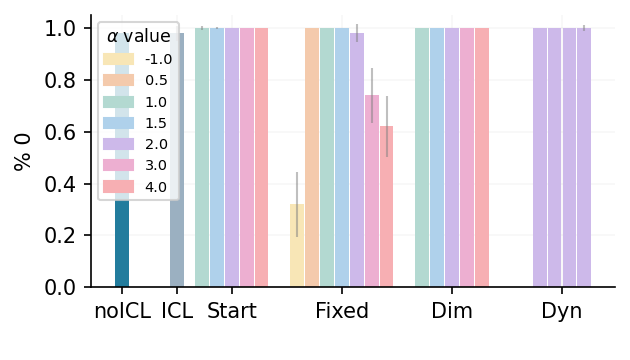

In [23]:
plot_task(
    task=avg_labels,
    ci_s=ci_labels,
    language_to_count=label_to_count,
    filename='ENi2f',
)

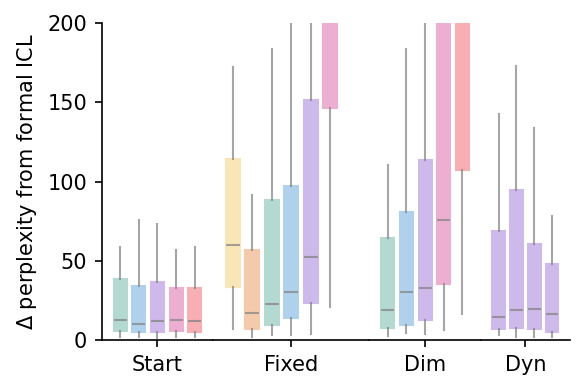

In [24]:
plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count='formal',
    filename='ENi2f-ppl',
    max_value=200,
    legend_on_ax=0,
)

## f2i

In [42]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENf2i/diff/all_evaluated_icl4_tok30_ENf2i-ENi2f.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = '1'

avg_perplexity = {}
avg_perplexity_filtered = {}
ci_perplexity = {}
ci_perplexity_filtered = {}
perplexity_filtered = {}

avg_language = {}
ci_language = {}

avg_labels = {}
ci_labels = {}
for k in ita_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in ita_res
    ]
    avg_perplexity[k] = np.mean(all_perplexity)
    ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in ita_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count and str(ele['eval_task']['icl']['output']) == label_to_count
    ]
    perplexity_filtered[k] = all_perplexity_filtered
    avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in ita_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in ita_res]
    avg_language[k] = np.mean(all_language_scores)
    ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [str(ele['eval_task'][k]['output']) for ele in ita_res]
    avg_labels[k] = all_labels.count(str(label_to_count)) / len(all_labels)
    all_scores = [ele['eval_task'][k][label_to_count] for ele in ita_res]
    ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

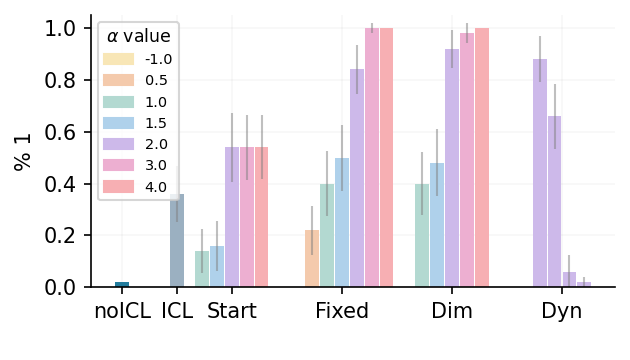

In [43]:
plot_task(
    task=avg_labels,
    ci_s=ci_labels,
    language_to_count=label_to_count,
    filename='ENf2i',
)

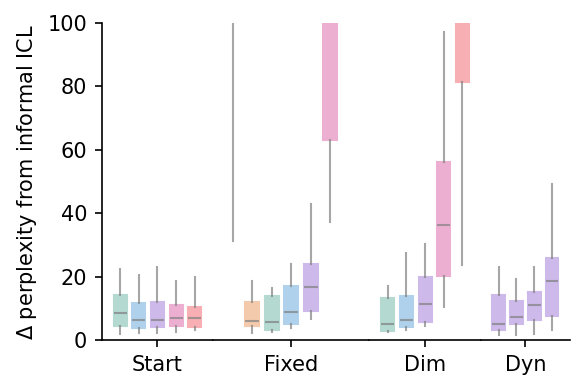

In [44]:
plot_perplexity(
    perplexity=perplexity_filtered,
    language_to_count='informal',
    filename='ENf2i-ppl',
    max_value=100,
    legend_on_ax=0,
)

# Deltas

## Languages

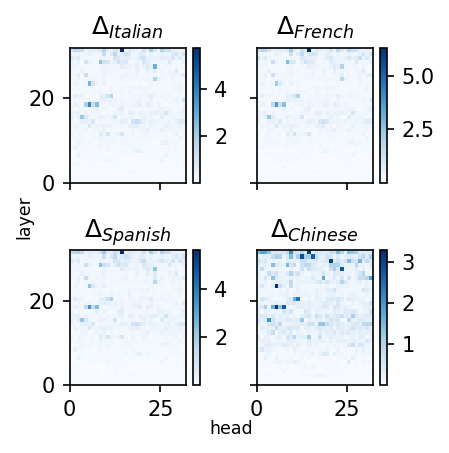

In [82]:
ita = torch.load('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/diff_mean_act_icl4_tok30_ITA-ENG.pt')
fra = torch.load('./../output/Mistral-7B-Instruct-v0.2/FRA/diff/diff_mean_act_icl4_tok30_FRA-ENG.pt')
spa = torch.load('./../output/Mistral-7B-Instruct-v0.2/SPA/diff/diff_mean_act_icl4_tok30_SPA-ENG.pt')
zho = torch.load('./../output/Mistral-7B-Instruct-v0.2/ZHO/diff/diff_mean_act_icl4_tok30_ZHO-ENG.pt')

languages = ['Italian', 'French', 'Spanish', 'Chinese']

from matplotlib import cm, colors
fig, axs = plt.subplots(2, 2, figsize=(3, 3), dpi=150, sharex=True, sharey=True)
axs = axs.flatten()

# parameters
aggregation_fun = torch.norm
gen_step = 0


cmap = cm.Blues if aggregation_fun == torch.norm else cm.BrBG

# vmin = -0.2  # Define your minimum value
# vmax = 0.2   # Define your maximum value

for i, (ax, head_matrix) in enumerate(zip(axs, [ita, fra, spa, zho])):
    ax.set_title(fr'$\Delta_{{\it{{{languages[i]}}}}}$')

    to_plot = aggregation_fun(head_matrix[gen_step], dim=-1)
    pc = ax.pcolormesh(
        to_plot,
        norm=colors.CenteredNorm() if aggregation_fun == torch.mean else None,
        cmap=cmap,
    )
    fig.colorbar(pc, ax=ax)

fig.tight_layout()
fig.supxlabel('head', fontsize='small')
fig.supylabel('layer', fontsize='small')
fig.savefig(f'./media/single/delta_lang_{aggregation_fun.__name__}.pdf', format='pdf', bbox_inches='tight')

# fig.suptitle(f"[step {gen_step}] {'Norm' if aggregation_fun == torch.norm else 'Mean'} activation difference for different languages ")

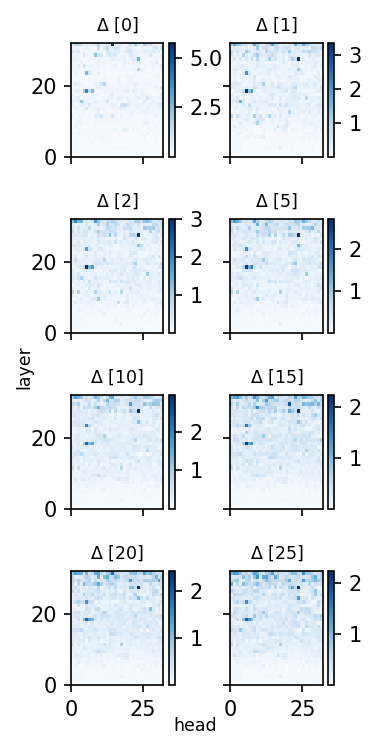

In [113]:
head_matrix = torch.load('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/diff_mean_act_icl4_tok30_ITA-ENG.pt')
language = 'Italian'

from matplotlib import cm, colors
fig, axs = plt.subplots(
    4, 2, 
    figsize=(2.5, 5), # (8, 1.4),
    dpi=150, sharex=True, sharey=True
)
axs = axs.flatten()

# parameters
aggregation_fun = torch.norm
gen_steps = [0, 1, 2, 5, 10, 15, 20, 25]


cmap = cm.Blues if aggregation_fun == torch.norm else cm.BrBG

# vmin = -0.2  # Define your minimum value
# vmax = 0.2   # Define your maximum value

for i, (ax, step) in enumerate(zip(axs, gen_steps)):
    ax.set_title(fr'$\Delta_{{\it{{{language}}}}}$[{step}]')
    ax.set_title(f'$\Delta$ [{step}]', fontsize='small')

    to_plot = aggregation_fun(head_matrix[step], dim=-1)
    pc = ax.pcolormesh(
        to_plot,
        norm=colors.CenteredNorm() if aggregation_fun == torch.mean else None,
        cmap=cmap,
    )
    fig.colorbar(pc, ax=ax)

fig.tight_layout()
fig.supylabel('layer', fontsize='small')
fig.supxlabel('head', fontsize='small')
fig.savefig(f'./media/single/delta_gen_{aggregation_fun.__name__}.pdf', format='pdf', bbox_inches='tight')

# fig.suptitle(f"[step {gen_step}] {'Norm' if aggregation_fun == torch.norm else 'Mean'} activation difference for different languages ")

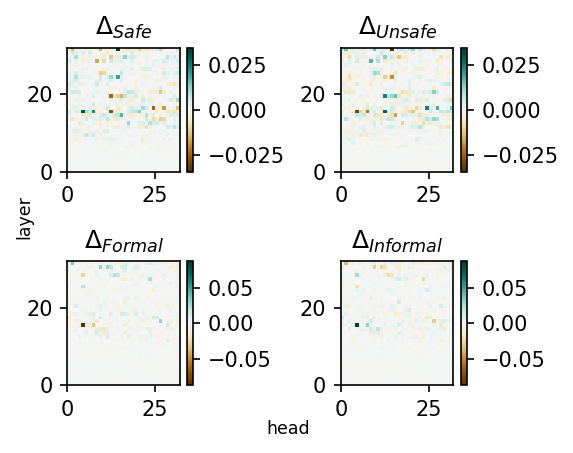

In [72]:
ita = torch.load('./../output/Mistral-7B-Instruct-v0.2/ENsafe/diff/diff_mean_act_icl4_tok30_ENsafe-ENunsafe.pt')
fra = torch.load('./../output/Mistral-7B-Instruct-v0.2/ENunsafe/diff/diff_mean_act_icl4_tok30_ENunsafe-ENsafe.pt')
spa = torch.load('./../output/Mistral-7B-Instruct-v0.2/ENi2f/diff/diff_mean_act_icl4_tok30_ENi2f-ENf2i.pt')
zho = torch.load('./../output/Mistral-7B-Instruct-v0.2/ENf2i/diff/diff_mean_act_icl4_tok30_ENf2i-ENi2f.pt')

tasks = ['Safe', 'Unsafe', 'Formal', 'Informal']

from matplotlib import cm, colors
fig, axs = plt.subplots(2, 2, figsize=(3.8, 3), dpi=150)
axs= axs.flatten()

# parameters
aggregation_fun = torch.mean
gen_step = 0

cmap = cm.Blues if aggregation_fun == torch.norm else cm.BrBG

# vmin = -0.2  # Define your minimum value
# vmax = 0.2   # Define your maximum value

for i, (ax, head_matrix) in enumerate(zip(axs, [ita, fra, spa, zho])):
    ax.set_title(fr'$\Delta_{{{tasks[i].capitalize()}}}$')

    to_plot = aggregation_fun(head_matrix[gen_step], dim=-1)
    pc = ax.pcolormesh(
        to_plot, 
        norm=colors.CenteredNorm() if aggregation_fun == torch.mean else None,
        cmap=cmap,
    )
    fig.colorbar(pc, ax=ax)

fig.tight_layout()
fig.supxlabel('head', fontsize='small')
fig.supylabel('layer', fontsize='small')
fig.savefig(f'./media/single/delta_task_{aggregation_fun.__name__}.pdf', format='pdf', bbox_inches='tight')

# Dynamic

## Languages

In [46]:
{
    "ITA": read_results('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/all_evaluated_icl4_tok30_ITA-ENG.json'),
    "FRA": read_results('./../output/Mistral-7B-Instruct-v0.2/FRA/diff/all_evaluated_icl4_tok30_FRA-ENG.json'),
    "SPA": read_results('./../output/Mistral-7B-Instruct-v0.2/SPA/diff/all_evaluated_icl4_tok30_SPA-ENG.json'),
    "ZHO": read_results('./../output/Mistral-7B-Instruct-v0.2/ZHO/diff/all_evaluated_icl4_tok30_ZHO-ENG.json'),
}

{'ITA': [{'prompt': 'Q: Name two types of desert biomes. \nA:',
   'gold': 'Due tipi di biomi desertici sono il deserto caldo e secco e il deserto freddo.',
   'output': {'icl': 'Due tipi di biomi desertici sono il deserto e il deserto arido.',
    'no_icl': 'Two types of desert biomes are the hot and dry desert, also known as arid deserts, and the cold desert, also known as polar',
    'dynamic_p0.5': 'Due tipi di biomi desertici sono il deserto roccioso (o deserto di roccia) e il deser',
    'dynamic_p0.6': 'Due tipi di biomi desertici sono il deserto roccioso (o deserto di roccia) e il deser',
    'dynamic_p0.7': 'Due tipi di biomi desertici sono il deserto roccioso (o desertico arido) e il deserto tropicale',
    'dynamic_p0.95': 'Due tipi di biomi desertici sono il deserto roccioso (deserti di roccia) e il deserto',
    'edited_-1.0': 'A desert biome is a dry and hot environment that receives little to no rainfall. Two common types of desert biomes are:',
    'edited_0.5': '1. A d

# For main

In [119]:
# two subplot one with metric and the other perplexity
# load ITA results
ita_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/all_evaluated_icl4_tok30_ITA-ENG.json')

language_to_count = 'it'
all_res = [
    read_results('./../output/Mistral-7B-Instruct-v0.2/ITA/diff/all_evaluated_icl4_tok30_ITA-ENG.json'),
    read_results('./../output/Mistral-7B-Instruct-v0.2/FRA/diff/all_evaluated_icl4_tok30_FRA-ENG.json'),
    read_results('./../output/Mistral-7B-Instruct-v0.2/SPA/diff/all_evaluated_icl4_tok30_SPA-ENG.json'),
]
latin_perplexity = {k: [] for k in all_res[0][0]['perplexity']}

latin_avg_language = {k: [] for k in all_res[0][0]['eval_lang']}
latin_ci_language = {k: [] for k in all_res[0][0]['eval_lang']}

latin_avg_labels = {k: [] for k in all_res[0][0]['eval_task']}
latin_ci_labels = {k: [] for k in all_res[0][0]['eval_task']}

for res, language_to_count in zip(all_res, ['it', 'fr', 'es']):
    # compute accuracy for task

    _avg_perplexity = {}
    # _avg_perplexity_filtered = {}
    _perplexity_filtered = {}        # all data
    # _avg_perplexity_filtered_tri = {}
    _ci_perplexity = {}
    # _ci_perplexity_filtered = {}

    _avg_language = {}
    _ci_language = {}

    _avg_labels = {}
    for k in res[0]['perplexity']:
        all_perplexity = [
            ele['perplexity'][k] for ele in res
        ]
        # _avg_perplexity[k] = np.mean(all_perplexity)
        _ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

        # correct perlexities (only when the icl is in the same language as the one to count)
        all_perplexity_filtered = [
            ele['perplexity'][k] for ele in res 
            if ele['eval_lang']['icl']['lang'] == language_to_count
        ]
        _perplexity_filtered[k] = all_perplexity_filtered
        # _avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
        # _ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))
        # _avg_perplexity_filtered_tri[k] = trim_mean(all_perplexity_filtered, 0.1)

        latin_perplexity[k].extend(_perplexity_filtered[k])

    for k in res[0]['output']:
        # all_languages = [ele['eval_lang'][k]['lang'] for ele in res]
        # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
        all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in res]
        _avg_language[k] = np.mean(all_language_scores)
        _ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

        latin_avg_language[k].append(_avg_language[k])
        latin_ci_language[k].append(_ci_language[k])

        label_to_count = 'unsafe'
        all_labels = [ele['eval_task'][k]['output'] for ele in res]
        _avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity

        latin_avg_labels[k].append(_avg_labels[k])

for k in latin_avg_language:
    latin_avg_labels[k] = np.mean(latin_avg_labels[k])
    latin_avg_language[k] = np.mean(latin_avg_language[k])
    latin_ci_language[k] = np.mean(latin_ci_language[k])

# no need to compute mean since i'm plotting with the boxplot
# for k in latin_perplexity:
#     latin_perplexity[k] = np.mean(np.array(latin_perplexity[k]), axis=-1)

In [120]:
zho_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ZHO/diff/all_evaluated_icl4_tok30_ZHO-ENG.json')

language_to_count = 'zh-cn'

# compute accuracy for task

zho_avg_perplexity = {}
zho_avg_perplexity_filtered = {}
zho_perplexity_filtered = {}        # all data
zho_avg_perplexity_filtered_tri = {}
zho_ci_perplexity = {}
zho_ci_perplexity_filtered = {}

zho_avg_language = {}
zho_ci_language = {}

zho_avg_labels = {}
for k in zho_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in zho_res
    ]
    zho_avg_perplexity[k] = np.mean(all_perplexity)
    zho_ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in zho_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    zho_perplexity_filtered[k] = all_perplexity_filtered
    zho_avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    zho_ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))
    zho_avg_perplexity_filtered_tri[k] = trim_mean(all_perplexity_filtered, 0.1)

for k in zho_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in zho_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in zho_res]
    zho_avg_language[k] = np.mean(all_language_scores)
    zho_ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    # label_to_count = 'unsafe'
    # all_labels = [ele['eval_task'][k]['output'] for ele in zho_res]
    # zho_avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)

In [59]:
# two subplot one with metric and the other perplexity
# load ITA results
unsafe_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENunsafe/diff/all_evaluated_icl4_tok30_ENunsafe-ENsafe.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = 'unsafe'

task_avg_perplexity = {}
task_avg_perplexity_filtered = {}
task_ci_perplexity = {}
task_ci_perplexity_filtered = {}
task_perplexity_filtered = {}

task_avg_language = {}
task_ci_language = {}

task_avg_labels = {}
task_ci_labels = {}
for k in unsafe_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in unsafe_res 
    ]
    task_avg_perplexity[k] = np.mean(all_perplexity)
    task_ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in unsafe_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    task_perplexity_filtered[k] = all_perplexity_filtered
    task_avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    task_ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in unsafe_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in unsafe_res]
    task_avg_language[k] = np.mean(all_language_scores)
    task_ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [ele['eval_task'][k]['output'] for ele in unsafe_res]
    task_avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity
    all_scores = [ele['eval_task'][k][label_to_count] for ele in unsafe_res]
    task_ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

In [121]:
# two subplot one with metric and the other perplexity
# load ITA results
safe_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENsafe/diff/all_evaluated_icl4_tok30_ENsafe-ENunsafe.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = 'safe'

task_safe_avg_perplexity = {}
task_safe_avg_perplexity_filtered = {}
task_safe_ci_perplexity = {}
task_safe_ci_perplexity_filtered = {}
task_safe_perplexity_filtered = {}

task_safe_avg_language = {}
task_safe_ci_language = {}

task_safe_avg_labels = {}
task_safe_ci_labels = {}
for k in safe_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in safe_res 
    ]
    task_safe_avg_perplexity[k] = np.mean(all_perplexity)
    task_safe_ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in safe_res 
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    task_safe_perplexity_filtered[k] = all_perplexity_filtered
    task_safe_avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    task_safe_ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in safe_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in safe_res]
    task_safe_avg_language[k] = np.mean(all_language_scores)
    task_safe_ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [ele['eval_task'][k]['output'] for ele in safe_res]
    task_safe_avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity
    all_scores = [ele['eval_task'][k][label_to_count] for ele in safe_res]
    task_safe_ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

In [122]:
# two subplot one with metric and the other perplexity
formality_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENf2i/diff/all_evaluated_icl4_tok30_ENf2i-ENi2f.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = '1'

form_avg_perplexity = {}
form_avg_perplexity_filtered = {}
form_ci_perplexity = {}
form_ci_perplexity_filtered = {}
form_perplexity_filtered = {}

form_avg_language = {}
form_ci_language = {}

form_avg_labels = {}
form_ci_labels = {}
for k in formality_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in formality_res
    ]
    form_avg_perplexity[k] = np.mean(all_perplexity)
    form_ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in formality_res
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    form_perplexity_filtered[k] = all_perplexity_filtered
    form_avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    form_ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in formality_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in formality_res]
    form_avg_language[k] = np.mean(all_language_scores)
    form_ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [str(ele['eval_task'][k]['output']) for ele in formality_res]
    form_avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity
    all_scores = [ele['eval_task'][k][label_to_count] for ele in formality_res]
    form_ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

In [123]:
# two subplot one with metric and the other perplexity
informality_res = read_results('./../output/Mistral-7B-Instruct-v0.2/ENi2f/diff/all_evaluated_icl4_tok30_ENi2f-ENf2i.json')

# compute accuracy for task
language_to_count = 'en'
label_to_count = '0'

inform_avg_perplexity = {}
inform_avg_perplexity_filtered = {}
inform_ci_perplexity = {}
inform_ci_perplexity_filtered = {}
inform_perplexity_filtered = {}

inform_avg_language = {}
inform_ci_language = {}

inform_avg_labels = {}
inform_ci_labels = {}
for k in informality_res[0]['perplexity']:
    all_perplexity = [
        ele['perplexity'][k] for ele in informality_res
    ]
    inform_avg_perplexity[k] = np.mean(all_perplexity)
    inform_ci_perplexity[k] = 1.96 * np.std(all_perplexity)/np.sqrt(len(all_perplexity))

    # correct perlexities (only when the icl is in the same language as the one to count)
    all_perplexity_filtered = [
        ele['perplexity'][k] for ele in informality_res
        if ele['eval_lang']['icl']['lang'] == language_to_count
    ]
    inform_perplexity_filtered[k] = all_perplexity_filtered
    inform_avg_perplexity_filtered[k] = np.mean(all_perplexity_filtered)
    inform_ci_perplexity_filtered[k] = 1.96 * np.std(all_perplexity_filtered)/np.sqrt(len(all_perplexity_filtered))

for k in informality_res[0]['output']:
    # all_languages = [ele['eval_lang'][k]['lang'] for ele in ita_res]
    # avg_language[k] = all_languages.count(language_to_count) / len(all_languages)
    all_language_scores = [ele['eval_lang'][k][language_to_count] for ele in informality_res]
    inform_avg_language[k] = np.mean(all_language_scores)
    inform_ci_language[k] = 1.96 * np.std(all_language_scores)/np.sqrt(len(all_language_scores))

    all_labels = [str(ele['eval_task'][k]['output']) for ele in informality_res]
    inform_avg_labels[k] = all_labels.count(label_to_count) / len(all_labels)      # inutile qui misurare la toxicity
    all_scores = [ele['eval_task'][k][label_to_count] for ele in informality_res]
    inform_ci_labels[k] = 1.96 * np.std(all_scores)/np.sqrt(len(all_scores))

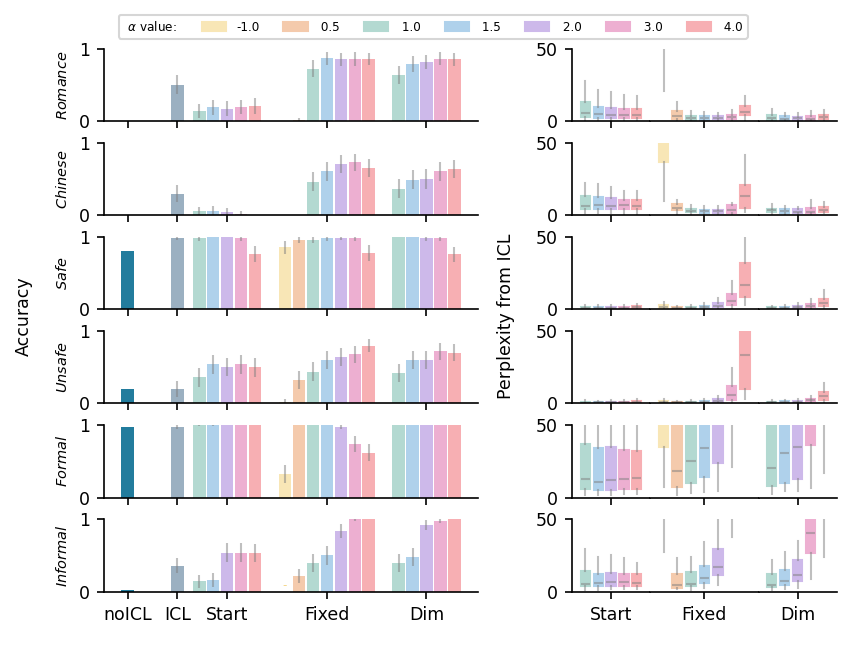

In [124]:
# fig = plt.figure(figsize=(8, 5), dpi=150)
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(6.3, 4.7), dpi=150)
gs_left = gridspec.GridSpec(nrows=6, ncols=1, width_ratios=[17])
gs_right = gridspec.GridSpec(nrows=6, ncols=3, width_ratios=[5, 7, 5])

ax0 = fig.add_subplot(gs_left[0])
ax_zho = fig.add_subplot(gs_left[1])
ax1_safe = fig.add_subplot(gs_left[2])
ax1 = fig.add_subplot(gs_left[3])
ax2in = fig.add_subplot(gs_left[4])
ax2 = fig.add_subplot(gs_left[5])

ax0_a = fig.add_subplot(gs_right[0,0])
ax0_b = fig.add_subplot(gs_right[0,1])
ax0_c = fig.add_subplot(gs_right[0,2])

ax_zho_a = fig.add_subplot(gs_right[1,0])
ax_zho_b = fig.add_subplot(gs_right[1,1])
ax_zho_c = fig.add_subplot(gs_right[1,2])

ax1_a = fig.add_subplot(gs_right[2,0])
ax1_b = fig.add_subplot(gs_right[2,1])
ax1_c = fig.add_subplot(gs_right[2,2])

ax1_safe_a = fig.add_subplot(gs_right[3,0])
ax1_safe_b = fig.add_subplot(gs_right[3,1])
ax1_safe_c = fig.add_subplot(gs_right[3,2])

ax2in_a = fig.add_subplot(gs_right[4,0])
ax2in_b = fig.add_subplot(gs_right[4,1])
ax2in_c = fig.add_subplot(gs_right[4,2])

ax2_a = fig.add_subplot(gs_right[5,0])
ax2_b = fig.add_subplot(gs_right[5,1])
ax2_c = fig.add_subplot(gs_right[5,2])


# now the plots are on top of each other, we'll have to adjust their edges so that they won't overlap
gs_left.update(right=0.52)
gs_right.update(left=0.62)

gs_right.update(wspace=0)
gs_left.update(hspace=0.3)
gs_right.update(hspace=0.3)
# add right and left ylabels
fig.text(0.04, 0.5, 'Accuracy', va='center', ha='center', rotation='vertical', fontsize='small')
fig.text(0.55, 0.5, 'Perplexity from ICL', va='center', ha='center', rotation='vertical', fontsize='small')

width = 0.25
distance = 0.03
error_kw = {"error_kw": dict(ecolor='gray', alpha=.5, lw=1)}

ax0.bar(0 - 0*width - 0*distance, latin_avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
# ax0.text(0 - 0*width - 0*distance, ita_avg_language['no_icl'], f"-", ha='center', va='bottom', fontsize = 'xx-small', color=palette1[0])
ax0.bar(1 - 0*width - 0*distance, latin_avg_language['icl'], width, color=icl_color, yerr=latin_ci_language['icl'], **error_kw)
ax0.bar(2 - 2*width - 2*distance, latin_avg_language['editedSTART_1.0'], width, color=cromos[2], yerr=latin_ci_language['editedSTART_1.0'], **error_kw)
ax0.bar(2 - 1*width - 1*distance, latin_avg_language['editedSTART_1.5'], width, color=cromos[3], yerr=latin_ci_language['editedSTART_1.5'], **error_kw)
ax0.bar(2 - 0*width - 0*distance, latin_avg_language['editedSTART_2.0'], width, color=cromos[4], yerr=latin_ci_language['editedSTART_2.0'], **error_kw)
ax0.bar(2 + 1*width + 1*distance, latin_avg_language['editedSTART_3.0'], width, color=cromos[5], yerr=latin_ci_language['editedSTART_3.0'], **error_kw)
ax0.bar(2 + 2*width + 2*distance, latin_avg_language['editedSTART_4.0'], width, color=cromos[6], yerr=latin_ci_language['editedSTART_4.0'], **error_kw)
ax0.bar(4 - 3*width - 3*distance, latin_avg_language['edited_-1.0'],width, color=cromos[0], yerr=latin_ci_language['edited_-1.0'], **error_kw)
# ax0.text(4 - 3*width - 3*distance, ita_avg_language['edited_-1.0'], f"-", ha='center', va='bottom', fontsize = 'xx-small', color=adjust_lightness(cromos[0], 1.6))
ax0.bar(4 - 2*width - 2*distance, latin_avg_language['edited_0.5'], width, color=cromos[1], yerr=latin_ci_language['edited_0.5'], **error_kw)
# ax0.text(4 - 2*width - 2*distance, ita_avg_language['edited_0.5'], f"-", ha='center', va='bottom', fontsize = 'xx-small', color=adjust_lightness(cromos[1], 1.6))
ax0.bar(4 - 1*width - 1*distance, latin_avg_language['edited_1.0'], width, color=cromos[2], yerr=latin_ci_language['edited_1.0'], **error_kw)
ax0.bar(4 + 0*width - 0*distance, latin_avg_language['edited_1.5'], width, color=cromos[3], yerr=latin_ci_language['edited_1.5'], **error_kw)
ax0.bar(4 + 1*width + 1*distance, latin_avg_language['edited_2.0'], width, color=cromos[4], yerr=latin_ci_language['edited_2.0'], **error_kw)
ax0.bar(4 + 2*width + 2*distance, latin_avg_language['edited_3.0'], width, color=cromos[5], yerr=latin_ci_language['edited_3.0'], **error_kw)
ax0.bar(4 + 3*width + 3*distance, latin_avg_language['edited_4.0'], width, color=cromos[6], yerr=latin_ci_language['edited_4.0'], **error_kw)
ax0.bar(6 - 2*width - 2*distance, latin_avg_language['editedDIM_1.0'], width, color=cromos[2], yerr=latin_ci_language['editedDIM_1.0'], **error_kw)
ax0.bar(6 - 1*width - 1*distance, latin_avg_language['editedDIM_1.5'], width, color=cromos[3], yerr=latin_ci_language['editedDIM_1.5'], **error_kw)
ax0.bar(6 - 0*width - 0*distance, latin_avg_language['editedDIM_2.0'], width, color=cromos[4], yerr=latin_ci_language['editedDIM_2.0'], **error_kw)
ax0.bar(6 + 1*width + 1*distance, latin_avg_language['editedDIM_3.0'], width, color=cromos[5], yerr=latin_ci_language['editedDIM_3.0'], **error_kw)
ax0.bar(6 + 2*width + 2*distance, latin_avg_language['editedDIM_4.0'], width, color=cromos[6], yerr=latin_ci_language['editedDIM_4.0'], **error_kw)

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n',
    'Fixed\n', 
    'Dim',
]
# commet to enable x_ticks
x0_labels = [f'' for x in x0_labels]
ax0.set_xticks([0, 1, 2, 4, 6], x0_labels, fontsize='x-small')
ax0.set_ylim(0, 1.0)
ax0.set_ylabel(r'$Romance$', fontsize='x-small')
y_ticks_int = [int(y) for y in ax0.get_yticks()]
ax0.set_yticks(y_ticks_int, y_ticks_int, fontsize='small')
ax0.set_axisbelow(True)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


start_data = [
    latin_perplexity['delta_editedSTART_1.0'],
    latin_perplexity['delta_editedSTART_1.5'],
    latin_perplexity['delta_editedSTART_2.0'],
    latin_perplexity['delta_editedSTART_3.0'],
    latin_perplexity['delta_editedSTART_4.0'],
]
fixed_data = [
    latin_perplexity['delta_edited_-1.0'],
    latin_perplexity['delta_edited_0.5'],
    latin_perplexity['delta_edited_1.0'],
    latin_perplexity['delta_edited_1.5'],
    latin_perplexity['delta_edited_2.0'],
    latin_perplexity['delta_edited_3.0'],
    latin_perplexity['delta_edited_4.0'],
]

diminishing_data = [
    latin_perplexity['delta_editedDIM_1.0'],
    latin_perplexity['delta_editedDIM_1.5'],
    latin_perplexity['delta_editedDIM_2.0'],
    latin_perplexity['delta_editedDIM_3.0'],
    latin_perplexity['delta_editedDIM_4.0'],
]

bplot = ax0_a.boxplot(start_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax0_b.boxplot(fixed_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[0:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax0_c.boxplot(diminishing_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

for i, ax in enumerate([ax0_a, ax0_b, ax0_c]):
    ax.set_ylim(0.0, 50)      # 20.5
    for label in ax.get_yticklabels():
        label.set_fontsize('small')
    if i > 0:
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax0_a.set_xlim(0, 6)
ax0_b.set_xlim(0, 8)
ax0_c.set_xlim(0, 6)

ax0_a.set_xticks([3], [''])
ax0_b.set_xticks([4], [''])
ax0_c.set_xticks([3], [''])

########################################################

ax_zho.bar(0 - 0*width - 0*distance, zho_avg_language['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax_zho.bar(1 - 0*width - 0*distance, zho_avg_language['icl'], width, color=icl_color, yerr=zho_ci_language['icl'], **error_kw)
ax_zho.bar(2 - 2*width - 2*distance, zho_avg_language['editedSTART_1.0'], width, color=cromos[2], yerr=zho_ci_language['editedSTART_1.0'], **error_kw)
ax_zho.bar(2 - 1*width - 1*distance, zho_avg_language['editedSTART_1.5'], width, color=cromos[3], yerr=zho_ci_language['editedSTART_1.5'], **error_kw)
ax_zho.bar(2 - 0*width - 0*distance, zho_avg_language['editedSTART_2.0'], width, color=cromos[4], yerr=zho_ci_language['editedSTART_2.0'], **error_kw)
ax_zho.bar(2 + 1*width + 1*distance, zho_avg_language['editedSTART_3.0'], width, color=cromos[5], yerr=zho_ci_language['editedSTART_3.0'], **error_kw)
ax_zho.bar(2 + 2*width + 2*distance, zho_avg_language['editedSTART_4.0'], width, color=cromos[6], yerr=zho_ci_language['editedSTART_4.0'], **error_kw)
ax_zho.bar(4 - 3*width - 3*distance, zho_avg_language['edited_-1.0'],width, color=cromos[0], yerr=zho_ci_language['edited_-1.0'], **error_kw)
ax_zho.bar(4 - 2*width - 2*distance, zho_avg_language['edited_0.5'], width, color=cromos[1], yerr=zho_ci_language['edited_0.5'], **error_kw)
ax_zho.bar(4 - 1*width - 1*distance, zho_avg_language['edited_1.0'], width, color=cromos[2], yerr=zho_ci_language['edited_1.0'], **error_kw)
ax_zho.bar(4 + 0*width - 0*distance, zho_avg_language['edited_1.5'], width, color=cromos[3], yerr=zho_ci_language['edited_1.5'], **error_kw)
ax_zho.bar(4 + 1*width + 1*distance, zho_avg_language['edited_2.0'], width, color=cromos[4], yerr=zho_ci_language['edited_2.0'], **error_kw)
ax_zho.bar(4 + 2*width + 2*distance, zho_avg_language['edited_3.0'], width, color=cromos[5], yerr=zho_ci_language['edited_3.0'], **error_kw)
ax_zho.bar(4 + 3*width + 3*distance, zho_avg_language['edited_4.0'], width, color=cromos[6], yerr=zho_ci_language['edited_4.0'], **error_kw)
ax_zho.bar(6 - 2*width - 2*distance, zho_avg_language['editedDIM_1.0'], width, color=cromos[2], yerr=zho_ci_language['editedDIM_1.0'], **error_kw)
ax_zho.bar(6 - 1*width - 1*distance, zho_avg_language['editedDIM_1.5'], width, color=cromos[3], yerr=zho_ci_language['editedDIM_1.5'], **error_kw)
ax_zho.bar(6 - 0*width - 0*distance, zho_avg_language['editedDIM_2.0'], width, color=cromos[4], yerr=zho_ci_language['editedDIM_2.0'], **error_kw)
ax_zho.bar(6 + 1*width + 1*distance, zho_avg_language['editedDIM_3.0'], width, color=cromos[5], yerr=zho_ci_language['editedDIM_3.0'], **error_kw)
ax_zho.bar(6 + 2*width + 2*distance, zho_avg_language['editedDIM_4.0'], width, color=cromos[6], yerr=zho_ci_language['editedDIM_4.0'], **error_kw)

x0_labels = [
    'Baseline', 'ICL', 
    'Start\n',
    'Fixed\n', 
    'Dim',
]
# commet to enable x_ticks
x0_labels = [f'' for x in x0_labels]
ax_zho.set_xticks([0, 1, 2, 4, 6], x0_labels, fontsize='x-small')
ax_zho.set_ylim(0, 1.0)
ax_zho.set_ylabel(r'$Chinese$', fontsize='x-small')
y_ticks_int = [int(y) for y in ax_zho.get_yticks()]
ax_zho.set_yticks(y_ticks_int, y_ticks_int, fontsize='small')
ax_zho.set_axisbelow(True)
ax_zho.spines['top'].set_visible(False)
ax_zho.spines['right'].set_visible(False)


start_data = [
    zho_perplexity_filtered['delta_editedSTART_1.0'],
    zho_perplexity_filtered['delta_editedSTART_1.5'],
    zho_perplexity_filtered['delta_editedSTART_2.0'],
    zho_perplexity_filtered['delta_editedSTART_3.0'],
    zho_perplexity_filtered['delta_editedSTART_4.0'],
]
fixed_data = [
    zho_perplexity_filtered['delta_edited_-1.0'],
    zho_perplexity_filtered['delta_edited_0.5'],
    zho_perplexity_filtered['delta_edited_1.0'],
    zho_perplexity_filtered['delta_edited_1.5'],
    zho_perplexity_filtered['delta_edited_2.0'],
    zho_perplexity_filtered['delta_edited_3.0'],
    zho_perplexity_filtered['delta_edited_4.0'],
]

diminishing_data = [
    zho_perplexity_filtered['delta_editedDIM_1.0'],
    zho_perplexity_filtered['delta_editedDIM_1.5'],
    zho_perplexity_filtered['delta_editedDIM_2.0'],
    zho_perplexity_filtered['delta_editedDIM_3.0'],
    zho_perplexity_filtered['delta_editedDIM_4.0'],
]

bplot = ax_zho_a.boxplot(start_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax_zho_b.boxplot(fixed_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[0:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax_zho_c.boxplot(diminishing_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

for i, ax in enumerate([ax_zho_a, ax_zho_b, ax_zho_c]):
    ax.set_ylim(0.0, 50)      # 20.5
    for label in ax.get_yticklabels():
        label.set_fontsize('small')
    if i > 0:
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax_zho_a.set_xlim(0, 6)
ax_zho_b.set_xlim(0, 8)
ax_zho_c.set_xlim(0, 6)

ax_zho_a.set_xticks([3], [''])
ax_zho_b.set_xticks([4], [''])
ax_zho_c.set_xticks([3], [''])

########################################################


ax1.bar(0 - 0*width - 0*distance, task_avg_labels['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax1.bar(1 - 0*width - 0*distance, task_avg_labels['icl'], width, color=icl_color, yerr=task_ci_labels['icl'], **error_kw)
ax1.bar(2 - 2*width - 2*distance, task_avg_labels['editedSTART_1.0'], width, color=cromos[2], yerr=task_ci_labels['editedSTART_1.0'], **error_kw)
ax1.bar(2 - 1*width - 1*distance, task_avg_labels['editedSTART_1.5'], width, color=cromos[3], yerr=task_ci_labels['editedSTART_1.5'], **error_kw)
ax1.bar(2 - 0*width - 0*distance, task_avg_labels['editedSTART_2.0'], width, color=cromos[4], yerr=task_ci_labels['editedSTART_2.0'], **error_kw)
ax1.bar(2 + 1*width + 1*distance, task_avg_labels['editedSTART_3.0'], width, color=cromos[5], yerr=task_ci_labels['editedSTART_3.0'], **error_kw)
ax1.bar(2 + 2*width + 2*distance, task_avg_labels['editedSTART_4.0'], width, color=cromos[6], yerr=task_ci_labels['editedSTART_4.0'], **error_kw)
ax1.bar(4 - 3*width - 3*distance, task_avg_labels['edited_-1.0'],width, color=cromos[0], yerr=task_ci_labels['edited_-1.0'], **error_kw)
# ax1.text(4 - 3*width - 3*distance, task_avg_labels['edited_-1.0'], f"-", ha='center', va='bottom', fontsize = 'xx-small', color=adjust_lightness(cromos[0], 1.6))
ax1.bar(4 - 2*width - 2*distance, task_avg_labels['edited_0.5'], width, color=cromos[1], yerr=task_ci_labels['edited_0.5'], **error_kw)
ax1.bar(4 - 1*width - 1*distance, task_avg_labels['edited_1.0'], width, color=cromos[2], yerr=task_ci_labels['edited_1.0'], **error_kw)
ax1.bar(4 + 0*width - 0*distance, task_avg_labels['edited_1.5'], width, color=cromos[3], yerr=task_ci_labels['edited_1.5'], **error_kw)
ax1.bar(4 + 1*width + 1*distance, task_avg_labels['edited_2.0'], width, color=cromos[4], yerr=task_ci_labels['edited_2.0'], **error_kw)
ax1.bar(4 + 2*width + 2*distance, task_avg_labels['edited_3.0'], width, color=cromos[5], yerr=task_ci_labels['edited_3.0'], **error_kw)
ax1.bar(4 + 3*width + 3*distance, task_avg_labels['edited_4.0'], width, color=cromos[6], yerr=task_ci_labels['edited_4.0'], **error_kw)
ax1.bar(6 - 2*width - 2*distance, task_avg_labels['editedDIM_1.0'], width, color=cromos[2], yerr=task_ci_labels['editedDIM_1.0'], **error_kw)
ax1.bar(6 - 1*width - 1*distance, task_avg_labels['editedDIM_1.5'], width, color=cromos[3], yerr=task_ci_labels['editedDIM_1.5'], **error_kw)
ax1.bar(6 - 0*width - 0*distance, task_avg_labels['editedDIM_2.0'], width, color=cromos[4], yerr=task_ci_labels['editedDIM_2.0'], **error_kw)
ax1.bar(6 + 1*width + 1*distance, task_avg_labels['editedDIM_3.0'], width, color=cromos[5], yerr=task_ci_labels['editedDIM_3.0'], **error_kw)
ax1.bar(6 + 2*width + 2*distance, task_avg_labels['editedDIM_4.0'], width, color=cromos[6], yerr=task_ci_labels['editedDIM_4.0'], **error_kw)


x1_labels = [
    '', '', 
    '',
    '', 
    '',
]
ax1.set_xticks([0, 1, 2, 4, 6], x1_labels, fontsize='small')
ax1.set_ylim(0, 1.0)
ax1.set_ylabel(r'$\it{Unsafe}$', fontsize='x-small')
y_ticks_int = [int(y) for y in ax1.get_yticks()]
ax1.set_yticks(y_ticks_int, y_ticks_int, fontsize='small')
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

start_data = [
    task_perplexity_filtered['delta_editedSTART_1.0'],
    task_perplexity_filtered['delta_editedSTART_1.5'],
    task_perplexity_filtered['delta_editedSTART_2.0'],
    task_perplexity_filtered['delta_editedSTART_3.0'],
    task_perplexity_filtered['delta_editedSTART_4.0'],
]
fixed_data = [
    task_perplexity_filtered['delta_edited_-1.0'],
    task_perplexity_filtered['delta_edited_0.5'],
    task_perplexity_filtered['delta_edited_1.0'],
    task_perplexity_filtered['delta_edited_1.5'],
    task_perplexity_filtered['delta_edited_2.0'],
    task_perplexity_filtered['delta_edited_3.0'],
    task_perplexity_filtered['delta_edited_4.0'],
]

diminishing_data = [
    task_perplexity_filtered['delta_editedDIM_1.0'],
    task_perplexity_filtered['delta_editedDIM_1.5'],
    task_perplexity_filtered['delta_editedDIM_2.0'],
    task_perplexity_filtered['delta_editedDIM_3.0'],
    task_perplexity_filtered['delta_editedDIM_4.0'],
]

bplot = ax1_a.boxplot(start_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax1_b.boxplot(fixed_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[0:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax1_c.boxplot(diminishing_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

for i, ax in enumerate([ax1_a, ax1_b, ax1_c]):
    ax.set_ylim(0.0, 50)        # 13
    for label in ax.get_yticklabels():
        label.set_fontsize('small')
    if i > 0:
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax1_a.set_xlim(0, 6)
ax1_b.set_xlim(0, 8)
ax1_c.set_xlim(0, 6)

ax1_a.set_xticks([3], [''], fontsize='small')
ax1_b.set_xticks([4], [''], fontsize='small')
ax1_c.set_xticks([3], [''], fontsize='small')


########################################################


ax1_safe.bar(0 - 0*width - 0*distance, 1-task_avg_labels['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax1_safe.bar(1 - 0*width - 0*distance, task_safe_avg_labels['icl'], width, color=icl_color, yerr=task_safe_ci_labels['icl'], **error_kw)
ax1_safe.bar(2 - 2*width - 2*distance, task_safe_avg_labels['editedSTART_1.0'], width, color=cromos[2], yerr=task_safe_ci_labels['editedSTART_1.0'], **error_kw)
ax1_safe.bar(2 - 1*width - 1*distance, task_safe_avg_labels['editedSTART_1.5'], width, color=cromos[3], yerr=task_safe_ci_labels['editedSTART_1.5'], **error_kw)
ax1_safe.bar(2 - 0*width - 0*distance, task_safe_avg_labels['editedSTART_2.0'], width, color=cromos[4], yerr=task_safe_ci_labels['editedSTART_2.0'], **error_kw)
ax1_safe.bar(2 + 1*width + 1*distance, task_safe_avg_labels['editedSTART_3.0'], width, color=cromos[5], yerr=task_safe_ci_labels['editedSTART_3.0'], **error_kw)
ax1_safe.bar(2 + 2*width + 2*distance, task_safe_avg_labels['editedSTART_4.0'], width, color=cromos[6], yerr=task_safe_ci_labels['editedSTART_4.0'], **error_kw)
ax1_safe.bar(4 - 3*width - 3*distance, task_safe_avg_labels['edited_-1.0'],width, color=cromos[0], yerr=task_safe_ci_labels['edited_-1.0'], **error_kw)
ax1_safe.bar(4 - 2*width - 2*distance, task_safe_avg_labels['edited_0.5'], width, color=cromos[1], yerr=task_safe_ci_labels['edited_0.5'], **error_kw)
ax1_safe.bar(4 - 1*width - 1*distance, task_safe_avg_labels['edited_1.0'], width, color=cromos[2], yerr=task_safe_ci_labels['edited_1.0'], **error_kw)
ax1_safe.bar(4 + 0*width - 0*distance, task_safe_avg_labels['edited_1.5'], width, color=cromos[3], yerr=task_safe_ci_labels['edited_1.5'], **error_kw)
ax1_safe.bar(4 + 1*width + 1*distance, task_safe_avg_labels['edited_2.0'], width, color=cromos[4], yerr=task_safe_ci_labels['edited_2.0'], **error_kw)
ax1_safe.bar(4 + 2*width + 2*distance, task_safe_avg_labels['edited_3.0'], width, color=cromos[5], yerr=task_safe_ci_labels['edited_3.0'], **error_kw)
ax1_safe.bar(4 + 3*width + 3*distance, task_safe_avg_labels['edited_4.0'], width, color=cromos[6], yerr=task_safe_ci_labels['edited_4.0'], **error_kw)
ax1_safe.bar(6 - 2*width - 2*distance, task_safe_avg_labels['editedDIM_1.0'], width, color=cromos[2], yerr=task_safe_ci_labels['editedDIM_1.0'], **error_kw)
ax1_safe.bar(6 - 1*width - 1*distance, task_safe_avg_labels['editedDIM_1.5'], width, color=cromos[3], yerr=task_safe_ci_labels['editedDIM_1.5'], **error_kw)
ax1_safe.bar(6 - 0*width - 0*distance, task_safe_avg_labels['editedDIM_2.0'], width, color=cromos[4], yerr=task_safe_ci_labels['editedDIM_2.0'], **error_kw)
ax1_safe.bar(6 + 1*width + 1*distance, task_safe_avg_labels['editedDIM_3.0'], width, color=cromos[5], yerr=task_safe_ci_labels['editedDIM_3.0'], **error_kw)
ax1_safe.bar(6 + 2*width + 2*distance, task_safe_avg_labels['editedDIM_4.0'], width, color=cromos[6], yerr=task_safe_ci_labels['editedDIM_4.0'], **error_kw)


x1_labels = [
    '', '', 
    '',
    '', 
    '',
]
ax1_safe.set_xticks([0, 1, 2, 4, 6], x1_labels, fontsize='small')
ax1_safe.set_ylim(0, 1.0)
ax1_safe.set_ylabel(r'$\it{Safe}$', fontsize='x-small')
y_ticks_int = [int(y) for y in ax1_safe.get_yticks()]
ax1_safe.set_yticks(y_ticks_int, y_ticks_int, fontsize='small')
ax1_safe.set_axisbelow(True)
ax1_safe.spines['top'].set_visible(False)
ax1_safe.spines['right'].set_visible(False)

start_data = [
    task_safe_perplexity_filtered['delta_editedSTART_1.0'],
    task_safe_perplexity_filtered['delta_editedSTART_1.5'],
    task_safe_perplexity_filtered['delta_editedSTART_2.0'],
    task_safe_perplexity_filtered['delta_editedSTART_3.0'],
    task_safe_perplexity_filtered['delta_editedSTART_4.0'],
]
fixed_data = [
    task_safe_perplexity_filtered['delta_edited_-1.0'],
    task_safe_perplexity_filtered['delta_edited_0.5'],
    task_safe_perplexity_filtered['delta_edited_1.0'],
    task_safe_perplexity_filtered['delta_edited_1.5'],
    task_safe_perplexity_filtered['delta_edited_2.0'],
    task_safe_perplexity_filtered['delta_edited_3.0'],
    task_safe_perplexity_filtered['delta_edited_4.0'],
]

diminishing_data = [
    task_safe_perplexity_filtered['delta_editedDIM_1.0'],
    task_safe_perplexity_filtered['delta_editedDIM_1.5'],
    task_safe_perplexity_filtered['delta_editedDIM_2.0'],
    task_safe_perplexity_filtered['delta_editedDIM_3.0'],
    task_safe_perplexity_filtered['delta_editedDIM_4.0'],
]

bplot = ax1_safe_a.boxplot(start_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax1_safe_b.boxplot(fixed_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[0:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax1_safe_c.boxplot(diminishing_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

for i, ax in enumerate([ax1_safe_a, ax1_safe_b, ax1_safe_c]):
    ax.set_ylim(0.0, 50)        # 13
    for label in ax.get_yticklabels():
        label.set_fontsize('small')
    if i > 0:
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax1_safe_a.set_xlim(0, 6)
ax1_safe_b.set_xlim(0, 8)
ax1_safe_c.set_xlim(0, 6)

ax1_safe_a.set_xticks([3], [''], fontsize='small')
ax1_safe_b.set_xticks([4], [''], fontsize='small')
ax1_safe_c.set_xticks([3], [''], fontsize='small')


########################################################

########################################################


ax2in.bar(0 - 0*width - 0*distance, inform_avg_labels['no_icl'], width, color=palette1[0], label = 'original model (baseline)')
ax2in.bar(1 - 0*width - 0*distance, inform_avg_labels['icl'], width, color=icl_color, yerr=inform_ci_labels['icl'], **error_kw)
ax2in.bar(2 - 2*width - 2*distance, inform_avg_labels['editedSTART_1.0'], width, color=cromos[2], yerr=inform_ci_labels['editedSTART_1.0'], **error_kw)
ax2in.bar(2 - 1*width - 1*distance, inform_avg_labels['editedSTART_1.5'], width, color=cromos[3], yerr=inform_ci_labels['editedSTART_1.5'], **error_kw)
ax2in.bar(2 - 0*width - 0*distance, inform_avg_labels['editedSTART_2.0'], width, color=cromos[4], yerr=inform_ci_labels['editedSTART_2.0'], **error_kw)
ax2in.bar(2 + 1*width + 1*distance, inform_avg_labels['editedSTART_3.0'], width, color=cromos[5], yerr=inform_ci_labels['editedSTART_3.0'], **error_kw)
ax2in.bar(2 + 2*width + 2*distance, inform_avg_labels['editedSTART_4.0'], width, color=cromos[6], yerr=inform_ci_labels['editedSTART_4.0'], **error_kw)
ax2in.bar(4 - 3*width - 3*distance, inform_avg_labels['edited_-1.0'],width, color=cromos[0], yerr=inform_ci_labels['edited_-1.0'], **error_kw)
ax2in.bar(4 - 2*width - 2*distance, inform_avg_labels['edited_0.5'], width, color=cromos[1], yerr=inform_ci_labels['edited_0.5'], **error_kw)
ax2in.bar(4 - 1*width - 1*distance, inform_avg_labels['edited_1.0'], width, color=cromos[2], yerr=inform_ci_labels['edited_1.0'], **error_kw)
ax2in.bar(4 + 0*width - 0*distance, inform_avg_labels['edited_1.5'], width, color=cromos[3], yerr=inform_ci_labels['edited_1.5'], **error_kw)
ax2in.bar(4 + 1*width + 1*distance, inform_avg_labels['edited_2.0'], width, color=cromos[4], yerr=inform_ci_labels['edited_2.0'], **error_kw)
ax2in.bar(4 + 2*width + 2*distance, inform_avg_labels['edited_3.0'], width, color=cromos[5], yerr=inform_ci_labels['edited_3.0'], **error_kw)
ax2in.bar(4 + 3*width + 3*distance, inform_avg_labels['edited_4.0'], width, color=cromos[6], yerr=inform_ci_labels['edited_4.0'], **error_kw)
ax2in.bar(6 - 2*width - 2*distance, inform_avg_labels['editedDIM_1.0'], width, color=cromos[2], yerr=inform_ci_labels['editedDIM_1.0'], **error_kw)
ax2in.bar(6 - 1*width - 1*distance, inform_avg_labels['editedDIM_1.5'], width, color=cromos[3], yerr=inform_ci_labels['editedDIM_1.5'], **error_kw)
ax2in.bar(6 - 0*width - 0*distance, inform_avg_labels['editedDIM_2.0'], width, color=cromos[4], yerr=inform_ci_labels['editedDIM_2.0'], **error_kw)
ax2in.bar(6 + 1*width + 1*distance, inform_avg_labels['editedDIM_3.0'], width, color=cromos[5], yerr=inform_ci_labels['editedDIM_3.0'], **error_kw)
ax2in.bar(6 + 2*width + 2*distance, inform_avg_labels['editedDIM_4.0'], width, color=cromos[6], yerr=inform_ci_labels['editedDIM_4.0'], **error_kw)


x1_labels = [
    '', '', 
    '',
    '', 
    '',
]
ax2in.set_xticks([0, 1, 2, 4, 6], x1_labels, fontsize='small')
ax2in.set_ylim(0, 1.0)
ax2in.set_ylabel(r'$\it{Formal}$', fontsize='x-small')
y_ticks_int = [int(y) for y in ax2in.get_yticks()]
ax2in.set_yticks(y_ticks_int, y_ticks_int, fontsize='small')
ax2in.set_axisbelow(True)
ax2in.spines['top'].set_visible(False)
ax2in.spines['right'].set_visible(False)

start_data = [
    inform_perplexity_filtered['delta_editedSTART_1.0'],
    inform_perplexity_filtered['delta_editedSTART_1.5'],
    inform_perplexity_filtered['delta_editedSTART_2.0'],
    inform_perplexity_filtered['delta_editedSTART_3.0'],
    inform_perplexity_filtered['delta_editedSTART_4.0'],
]
fixed_data = [
    inform_perplexity_filtered['delta_edited_-1.0'],
    inform_perplexity_filtered['delta_edited_0.5'],
    inform_perplexity_filtered['delta_edited_1.0'],
    inform_perplexity_filtered['delta_edited_1.5'],
    inform_perplexity_filtered['delta_edited_2.0'],
    inform_perplexity_filtered['delta_edited_3.0'],
    inform_perplexity_filtered['delta_edited_4.0'],
]

diminishing_data = [
    inform_perplexity_filtered['delta_editedDIM_1.0'],
    inform_perplexity_filtered['delta_editedDIM_1.5'],
    inform_perplexity_filtered['delta_editedDIM_2.0'],
    inform_perplexity_filtered['delta_editedDIM_3.0'],
    inform_perplexity_filtered['delta_editedDIM_4.0'],
]

bplot = ax2in_a.boxplot(start_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax2in_b.boxplot(fixed_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[0:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax2in_c.boxplot(diminishing_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

for i, ax in enumerate([ax2in_a, ax2in_b, ax2in_c]):
    ax.set_ylim(0.0, 50)       # 200
    for label in ax.get_yticklabels():
        label.set_fontsize('small')
    if i > 0:
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax2in_a.set_xlim(0, 6)
ax2in_b.set_xlim(0, 8)
ax2in_c.set_xlim(0, 6)

ax2in_a.set_xticks([3], [''], fontsize='small')
ax2in_b.set_xticks([4], [''], fontsize='small')
ax2in_c.set_xticks([3], [''], fontsize='small')


########################################################

ax2.bar(0 - 0*width - 0*distance, form_avg_labels['no_icl'], width, color=palette1[0])
ax2.bar(1 - 0*width - 0*distance, form_avg_labels['icl'], width, color=icl_color, yerr=form_ci_labels['icl'], **error_kw)
ax2.bar(2 - 2*width - 2*distance, form_avg_labels['editedSTART_1.0'], width, color=cromos[2], yerr=form_ci_labels['editedSTART_1.0'], **error_kw)
ax2.bar(2 - 1*width - 1*distance, form_avg_labels['editedSTART_1.5'], width, color=cromos[3], yerr=form_ci_labels['editedSTART_1.5'], **error_kw)
ax2.bar(2 - 0*width - 0*distance, form_avg_labels['editedSTART_2.0'], width, color=cromos[4], yerr=form_ci_labels['editedSTART_2.0'], **error_kw)
ax2.bar(2 + 1*width + 1*distance, form_avg_labels['editedSTART_3.0'], width, color=cromos[5], yerr=form_ci_labels['editedSTART_3.0'], **error_kw)
ax2.bar(2 + 2*width + 2*distance, form_avg_labels['editedSTART_4.0'], width, color=cromos[6], yerr=form_ci_labels['editedSTART_4.0'], **error_kw)
ax2.bar(4 - 3*width - 3*distance, form_avg_labels['edited_-1.0'],width, color=cromos[0], yerr=form_ci_labels['edited_-1.0'], **error_kw)
ax2.text(4 - 3*width - 3*distance, form_avg_labels['edited_-1.0'], f"-", ha='center', va='bottom', fontsize = 'xx-small', color=adjust_lightness(cromos[0], 1.6))
ax2.bar(4 - 2*width - 2*distance, form_avg_labels['edited_0.5'], width, color=cromos[1], yerr=form_ci_labels['edited_0.5'], **error_kw)
ax2.bar(4 - 1*width - 1*distance, form_avg_labels['edited_1.0'], width, color=cromos[2], yerr=form_ci_labels['edited_1.0'], **error_kw)
ax2.bar(4 + 0*width - 0*distance, form_avg_labels['edited_1.5'], width, color=cromos[3], yerr=form_ci_labels['edited_1.5'], **error_kw)
ax2.bar(4 + 1*width + 1*distance, form_avg_labels['edited_2.0'], width, color=cromos[4], yerr=form_ci_labels['edited_2.0'], **error_kw)
ax2.bar(4 + 2*width + 2*distance, form_avg_labels['edited_3.0'], width, color=cromos[5], yerr=form_ci_labels['edited_3.0'], **error_kw)
ax2.bar(4 + 3*width + 3*distance, form_avg_labels['edited_4.0'], width, color=cromos[6], yerr=form_ci_labels['edited_4.0'], **error_kw)
ax2.bar(6 - 2*width - 2*distance, form_avg_labels['editedDIM_1.0'], width, color=cromos[2], yerr=form_ci_labels['editedDIM_1.0'], **error_kw)
ax2.bar(6 - 1*width - 1*distance, form_avg_labels['editedDIM_1.5'], width, color=cromos[3], yerr=form_ci_labels['editedDIM_1.5'], **error_kw)
ax2.bar(6 - 0*width - 0*distance, form_avg_labels['editedDIM_2.0'], width, color=cromos[4], yerr=form_ci_labels['editedDIM_2.0'], **error_kw)
ax2.bar(6 + 1*width + 1*distance, form_avg_labels['editedDIM_3.0'], width, color=cromos[5], yerr=form_ci_labels['editedDIM_3.0'], **error_kw)
ax2.bar(6 + 2*width + 2*distance, form_avg_labels['editedDIM_4.0'], width, color=cromos[6], yerr=form_ci_labels['editedDIM_4.0'], **error_kw)

x2_labels = [
    'noICL', 'ICL', 
    'Start\n',
    'Fixed\n', 
    'Dim',
]
ax2.set_xticks([0, 1, 2, 4, 6], x2_labels, fontsize='small')
ax2.set_ylim(0, 1.0)
ax2.set_ylabel(r'$\it{Informal}$', fontsize='x-small')
y_ticks_int = [int(y) for y in ax2.get_yticks()]
ax2.set_yticks(y_ticks_int, y_ticks_int, fontsize='small')
ax2.set_axisbelow(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


start_data = [
    form_perplexity_filtered['delta_editedSTART_1.0'],
    form_perplexity_filtered['delta_editedSTART_1.5'],
    form_perplexity_filtered['delta_editedSTART_2.0'],
    form_perplexity_filtered['delta_editedSTART_3.0'],
    form_perplexity_filtered['delta_editedSTART_4.0'],
]
fixed_data = [
    form_perplexity_filtered['delta_edited_-1.0'],
    form_perplexity_filtered['delta_edited_0.5'],
    form_perplexity_filtered['delta_edited_1.0'],
    form_perplexity_filtered['delta_edited_1.5'],
    form_perplexity_filtered['delta_edited_2.0'],
    form_perplexity_filtered['delta_edited_3.0'],
    form_perplexity_filtered['delta_edited_4.0'],
]

diminishing_data = [
    form_perplexity_filtered['delta_editedDIM_1.0'],
    form_perplexity_filtered['delta_editedDIM_1.5'],
    form_perplexity_filtered['delta_editedDIM_2.0'],
    form_perplexity_filtered['delta_editedDIM_3.0'],
    form_perplexity_filtered['delta_editedDIM_4.0'],
]

bplot = ax2_a.boxplot(start_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax2_b.boxplot(fixed_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[0:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

bplot = ax2_c.boxplot(diminishing_data, widths=0.7, patch_artist=True, showfliers=False, showcaps=False)
for w in bplot['whiskers']:
    w.set_color('gray')
    w.set_alpha(error_kw['error_kw']['alpha'])
for patch, median, color in zip(bplot['boxes'], bplot['medians'], cromos[2:]):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    median.set_color('gray')
    median.set_alpha(error_kw['error_kw']['alpha'])

for i, ax in enumerate([ax2_a, ax2_b, ax2_c]):
    ax.set_ylim(0.0, 50)        # 50
    for label in ax.get_yticklabels():
        label.set_fontsize('small')
    if i > 0:
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax2_a.set_xlim(0, 6)
ax2_b.set_xlim(0, 8)
ax2_c.set_xlim(0, 6)

ax2_a.set_xticks([3], ['Start'], fontsize='small')
ax2_b.set_xticks([4], ['Fixed'], fontsize='small')
ax2_c.set_xticks([3], ['Dim'], fontsize='small')

legend_patches = [
    mpatches.Patch(color=cromos[0], label='-1.0'),
    mpatches.Patch(color=cromos[1], label=' 0.5'),
    mpatches.Patch(color=cromos[2], label=' 1.0'),
    mpatches.Patch(color=cromos[3], label=' 1.5'),
    mpatches.Patch(color=cromos[4], label=' 2.0'),
    mpatches.Patch(color=cromos[5], label=' 3.0'),
    mpatches.Patch(color=cromos[6], label=' 4.0'),
]
legend = ax0.legend(
    handles=legend_patches,# labels=amount_of_edit, 
    # loc='upper left', 
    title=r' $\alpha$ value: ', 
    ncol=7, fontsize='xx-small', handler_map = {list: HandlerTuple(None)},
    # bbox_to_anchor=(0.18, 0.12),
    bbox_to_anchor=(1.74, 1.55),
)
plt.setp(legend.get_title(),fontsize='xx-small')
def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)
# legend._legend_box.align = "left"


# ax0.set_title('Steering scores', fontsize='small')
# ax0_b.set_title(r'$\Delta$ perlexity on ICL', fontsize='small')

# fig.tight_layout()
fig.savefig(f'./media/single/main_ITA_ENG.pdf', format='pdf', bbox_inches='tight')